# Predicting BTC price with LSTM NN model
We will explore predicing BTC price using an LSTM NN model. LSTM models are a specific instance of RNN, or Recurrent Neural Network. LSTMs are interesting because they carry state from previous timestamps into the prediction of a future value. So, for example, a chain of inputs from t0 - t9 can be input to predict the value at t10.

#### The Data
First, we will import the data from kaggle.

In [1]:
import pandas as pd

dir_path = "/home/agiles/.cache/kagglehub/datasets/mczielinski/bitcoin-historical-data/versions/71"
latest_file = "btcusd_1-min_data.csv"
df = pd.read_csv(dir_path + "/" + latest_file)

print(df.head())

      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0


In [2]:
from datetime import datetime
sanitized_df = df[df['Timestamp'].notna()]
sanitized_df = sanitized_df[sanitized_df['Volume'] != 0]

Notice the timestamp field isn't very useful to us. We will add a datetime field that is more human-readable.

In [4]:
datetime.fromtimestamp(sanitized_df["Timestamp"][col_len - 1])

datetime.datetime(2024, 11, 13, 19, 0)

Okay, that works. Let's apply the `datetime.fromtimestamp` function to all `Timestamp`s:

In [3]:
sanitized_df['Datetime'] = sanitized_df['Timestamp'].apply(datetime.fromtimestamp)

Let's check it out!

In [43]:
print(sanitized_df.head())

         Timestamp  Open  High   Low  Close     Volume            Datetime
627   1.325450e+09  4.84  4.84  4.84   4.84  10.000000 2012-01-01 15:28:00
1064  1.325476e+09  5.00  5.00  5.00   5.00  10.100000 2012-01-01 22:45:00
2343  1.325553e+09  5.00  5.00  5.00   5.00  19.048000 2012-01-02 20:04:00
3284  1.325609e+09  5.32  5.32  5.32   5.32   2.419173 2012-01-03 11:45:00
3441  1.325619e+09  5.14  5.14  5.14   5.14   0.680000 2012-01-03 14:22:00


In [7]:
sanitized_df['Open']

0              4.58
1              4.58
2              4.58
3              4.58
4              4.58
             ...   
6713275    90487.00
6713276    90475.00
6713277    90517.00
6713278    90567.00
6713279    90498.00
Name: Open, Length: 6713280, dtype: float64

In [174]:
import matplotlib.pyplot as plt

In [9]:
%%script false --no-raise-error
#no_ts_df = sanitized_df.drop('Timestamp', axis=1)
sanitized_df.plot(kind="line", x="Datetime", y="Close", grid=True, label="BTC Close")
plt.show()

In [10]:
%%script false --no-raise-error
sanitized_df.plot(kind="line", x="Datetime", y="High", grid=True, label="BTC High")
plt.show()

In [4]:
sanitized_df['Avg'] = (sanitized_df['High'] + sanitized_df['Low']) / 2

/tmp/ipykernel_6828/4113907236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sanitized_df['Avg'] = (sanitized_df['High'] + sanitized_df['Low']) / 2


<Axes: xlabel='Datetime'>

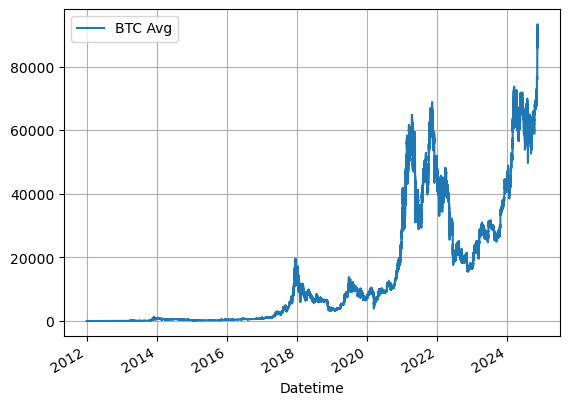

In [11]:
sanitized_df.plot(kind="line", x="Datetime", y="Avg", grid=True, label="BTC Avg")

In [5]:
df_len = len(sanitized_df)
last_couple_years = sanitized_df.tail(int(0.2 * df_len))

In [ ]:
last_couple_years.plot(kind="line", x="Datetime", y="Avg", grid=True, label="BTC Avg")

In [8]:
%%script false --no-raise-error
fig, ax = plt.subplots()
for name in ['Avg', 'High', 'Low', 'Open', 'Close', 'Volume']:
    ax.plot(last_couple_years['Datetime'], last_couple_years[name], label=name)

ax.set_xlabel('Datetime')
ax.set_ylabel('$')
ax.legend(loc='best')
plt.show()

In [6]:
# %%script false --no-raise-error
last_couple_years['Volume']

5370624    0.000000
5370625    0.002070
5370626    0.031820
5370627    0.013670
5370628    0.017537
             ...   
6713275    0.016974
6713276    0.243731
6713277    1.960700
6713278    0.159562
6713279    0.120893
Name: Volume, Length: 1342656, dtype: float64

In [63]:
last_couple_years.tail()

,Timestamp,Open,High,Low,Close,Volume,Datetime,Avg
6713275,1.731542e+09,90487.0,90519.0,90487.0,90508.0,0.016974,2024-11-13 18:56:00,90503.0
6713276,1.731542e+09,90475.0,90528.0,90475.0,90515.0,0.243731,2024-11-13 18:57:00,90501.5
6713277,1.731542e+09,90517.0,90620.0,90512.0,90589.0,1.960700,2024-11-13 18:58:00,90566.0
6713278,1.731542e+09,90567.0,90567.0,90521.0,90521.0,0.159562,2024-11-13 18:59:00,90544.0
6713279,1.731542e+09,90498.0,90626.0,90498.0,90566.0,0.120893,2024-11-13 19:00:00,90562.0


In [185]:
primed_data = last_couple_years.copy()
primed_data.head()

,Timestamp,Open,High,Low,Close,Volume,Datetime,Avg
5594826,1.661138e+09,21618.0,21632.0,21618.0,21632.0,0.022031,2022-08-21 23:07:00,21625.0
5594827,1.661138e+09,21643.0,21643.0,21627.0,21627.0,0.748464,2022-08-21 23:08:00,21635.0
5594828,1.661138e+09,21632.0,21644.0,21632.0,21632.0,0.022800,2022-08-21 23:09:00,21638.0
5594829,1.661138e+09,21638.0,21638.0,21638.0,21638.0,0.016510,2022-08-21 23:10:00,21638.0
5594830,1.661138e+09,21642.0,21642.0,21625.0,21625.0,0.959535,2022-08-21 23:11:00,21633.5


In [186]:
datetime_col.iloc[1] - datetime_col.iloc[0]
## Outputs diff of 1 minute, i.e. minutely data

Timedelta('0 days 12:53:00')

Let's now aggregates all of our data into a new set that is grouped by half day

In [187]:
primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day])['High'].max()
from pandas import DataFrame

aggregated_data = DataFrame()
aggregated_data['High'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['High'].max()
aggregated_data['Low'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['Low'].min()
aggregated_data['Avg'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['Avg'].mean()
aggregated_data['Open'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['Open'].first()
aggregated_data['Close'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['Close'].last()
aggregated_data['Volume'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['Volume'].sum()
aggregated_data['Datetime'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['Datetime'].min()
primed_data = aggregated_data

/tmp/ipykernel_96/1847439670.py:5: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  aggregated_data['High'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['High'].max()
/tmp/ipykernel_96/1847439670.py:6: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  aggregated_data['Low'] = primed_data.groupby([primed_data['Datetime'].dt.year, primed_data['Datetime'].dt.month, primed_data['Datetime'].dt.day, primed_data['Datetime'].dt.hour < 12], as_index=False)['Low'].min()


In [188]:
primed_data.head()

,High,Low,Avg,Open,Close,Volume,Datetime
0,21644.0,21509.0,21569.078431,21618.0,21514.0,26.991001,2022-08-21 23:07:00
1,21530.0,20968.0,21206.126056,21242.0,21411.0,722.107459,2022-08-22 12:00:00
2,21520.0,20901.0,21327.613304,21517.0,21248.0,706.882222,2022-08-22 00:00:00
3,21672.0,21331.0,21490.505634,21466.0,21520.0,503.991687,2022-08-23 12:00:00
4,21547.0,20899.0,21296.838450,21404.0,21451.0,733.163788,2022-08-23 00:00:00


In [189]:
primed_data[primed_data.isna().any(axis=1)]

,High,Low,Avg,Open,Close,Volume,Datetime


In [191]:
datetime_col = primed_data['Datetime']
primed_data = primed_data.drop("Datetime", axis=1)
volume_col = primed_data['Volume']
primed_data = primed_data.drop("Volume", axis=1)


In [192]:
for col in primed_data.columns.tolist():
    primed_data[f"percent_change_{col}"] = primed_data[col].pct_change()
    primed_data = primed_data.drop(col, axis=1)
# percent_change = {}
# for col in primed_data.columns.tolist():
#     percent_change[col] = [0]
# for i in range(1, len(primed_data)):
#     for col in primed_data.columns.tolist():
#         percent_change[col].append(primed_data.iloc[i][col] / primed_data.iloc[i - 1][col] - 1) # percent change
#         
# for col in primed_data.columns.tolist():
#     primed_data[f'percent_change_{col}'] = percent_change[col]
#     primed_data = primed_data.drop(col, axis=1)

In [193]:
len(primed_data)
primed_data['percent_change_High'][0:10]
primed_data.iloc[0] = primed_data.iloc[0].fillna(0)

In [195]:
primed_data = primed_data[['percent_change_High', 'percent_change_Low', 'percent_change_Open', 'percent_change_Close', 'percent_change_Avg']]
primed_data['percent_change_Avg'][0:10]

0    0.000000
1   -0.016827
2    0.005729
3    0.007638
4   -0.009012
5    0.014222
6   -0.011678
7    0.011861
8    0.000218
9   -0.034148
Name: percent_change_Avg, dtype: float64

In [196]:
timesteps = 20
features = primed_data.shape[1] - 1

In [197]:
import numpy as np
dlen = len(primed_data) - timesteps
X_shape = (dlen, timesteps, features)
y_shape = (dlen)
X, y = np.empty(X_shape), np.empty(y_shape)
for i in range(dlen):
    if i % 50000 == 0:
        print(f"Processing {i}th entry")
    for j in range(timesteps):
        for k in range(features):
            X[i,j,k] = primed_data.iloc[i + j, k]
    # X[i] = primed_data.iloc[i:i+timesteps, :-1].values  # Select features
    # y[i] = primed_data.iloc[i+timesteps, -1]           # Select corresponding
    y[i] = primed_data.iloc[i+timesteps, -1]           # Select corresponding

Processing 0th entry


In [172]:
X[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-5.26704860e-03, -2.51522618e-02, -1.73929133e-02,
        -4.78758018e-03,  2.57536380e+01],
       [-4.64468184e-04, -3.19534529e-03,  1.29460503e-02,
        -7.61290925e-03, -2.10844465e-02],
       [ 7.06319703e-03,  2.05731783e-02, -2.37021890e-03,
         1.28012048e-02, -2.87021698e-01],
       [-5.76781100e-03, -2.02522151e-02, -2.88828846e-03,
        -3.20631970e-03,  4.54714050e-01],
       [ 1.60115097e-02,  2.10536389e-02,  1.82208933e-03,
        -3.68281199e-03,  4.02163996e-01],
       [-1.56221451e-02, -9.23192277e-03,  3.73082125e-03,
         3.41568407e-03, -2.24097586e-01],
       [ 1.03944316e-02,  1.32437802e-02,  9.24592297e-03,
         5.87549545e-03, -1.43923144e-01],
       [ 1.79112703e-03, -4.80814116e-03, -1.64809870e-02,
         6.90742200e-03, -3.37880363e-01],
       [ 2.61312062e-03, -5.62878184e-02, -7.77008051e-03,
        -6.76795580e-02

In [199]:
np.save('btc_prepared_X', X)
np.save('btc_prepared_y', y)

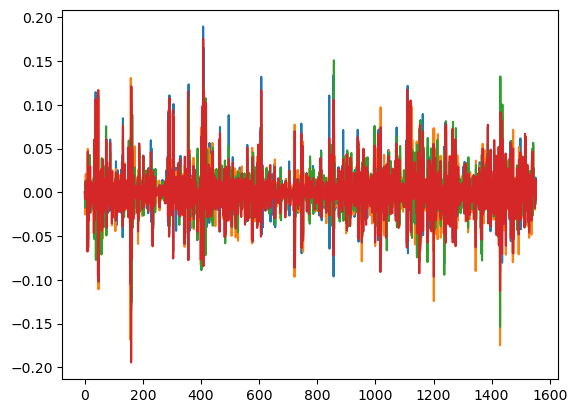

-0.1944698122780315

In [198]:
data_to_plot = X[:, 0, :]
for j in range(data_to_plot.shape[1]):
    plt.plot(data_to_plot[:, j], label=f"Feature {j}")
plt.show()
np.min(X)

In [204]:
X[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00526705, -0.02515226, -0.01739291, -0.00478758],
       [-0.00046447, -0.00319535,  0.01294605, -0.00761291],
       [ 0.0070632 ,  0.02057318, -0.00237022,  0.0128012 ],
       [-0.00576781, -0.02025222, -0.00288829, -0.00320632],
       [ 0.01601151,  0.02105364,  0.00182209, -0.00368281],
       [-0.01562215, -0.00923192,  0.00373082,  0.00341568],
       [ 0.01039443,  0.01324378,  0.00924592,  0.0058755 ],
       [ 0.00179113, -0.00480814, -0.01648099,  0.00690742],
       [ 0.00261312, -0.05628782, -0.00777008, -0.06767956],
       [-0.01188843,  0.04975396,  0.01660534,  0.0465679 ],
       [-0.0631652 , -0.06410985, -0.06213457, -0.05416883],
       [ 0.00647073,  0.00905595,  0.00153382,  0.00848092],
       [-0.01064978, -0.02100777, -0.01047327, -0.03255009],
       [-0.00044645,  0.02099764,  0.00069895,  0.02449251],
       [ 0.01315136, -0.00667135, -0.01097585,  0.0132761 ],
       [-0.02316924, -0.

In [203]:
X = np.load('btc_prepared_X.npy')
y = np.load('btc_prepared_y.npy')

In [205]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split into training + validation and test sets (80% train/val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training + validation into training and validation sets (e.g., 80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Check the sizes
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Print some basic stats
print(f"Train set max: {X_train.max()}")
print(f"Train set min: {X_train.min()}")
print(f"Validation set max: {X_val.max()}")
print(f"Validation set min: {X_val.min()}")
print(f"Test set max: {X_test.max()}")
print(f"Test set min: {X_test.min()}")

Train set: (931, 20, 4), (931,)
Validation set: (311, 20, 4), (311,)
Test set: (311, 20, 4), (311,)
Train set max: 0.18962017976224987
Train set min: -0.1944698122780315
Validation set max: 0.18962017976224987
Validation set min: -0.1944698122780315
Test set max: 0.18962017976224987
Test set min: -0.1944698122780315


In [206]:
from sklearn.preprocessing import MinMaxScaler

# Scalers for the training set (DO NOT include test/validation sets..that would leak data into the model)
x_train_scaler = MinMaxScaler((-1, 1))
y_train_scaler = MinMaxScaler((-1, 1))
X_train_scaled = x_train_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = y_train_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)

# Scalers for test set
x_test_scaler = MinMaxScaler((-1, 1))
y_test_scaler = MinMaxScaler((-1, 1))
X_test_scaled = x_test_scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = y_test_scaler.fit_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Scalers for validation set
x_val_scaler = MinMaxScaler((-1, 1))
y_val_scaler = MinMaxScaler((-1, 1))
X_val_scaled = x_val_scaler.fit_transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = y_val_scaler.fit_transform(y_val.reshape(-1, 1)).reshape(y_val.shape)

In [207]:
import tensorflow as tf
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))
dataset = dataset.batch(batch_size).shuffle(buffer_size=100)

In [208]:
y_train[-10:-1]
np.min(y_train)
np.max(y_train)

0.15792810647999755

In [211]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, features)),  # LSTM layer
    Dropout(0.2),
    LSTM(32, return_sequences=False),  # LSTM layer
    Dropout(0.2),
    Dense(16, activation='relu'),  # Output layer (single label)
    Dense(1, activation='linear')  # Output layer (single label)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(dataset, epochs=10)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0237   
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0244
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291 
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0273 
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230 


In [144]:
print(X_train_scaled.max())
print(X_train_scaled.min())
print(y_train_scaled.max())
print(y_train_scaled.min())

1.0
-1.0
1.0
-1.0


In [157]:
print(X_test_scaled.max())
print(X_test_scaled.min())
print(y_test_scaled.max())
print(y_test_scaled.min())
print(X_test_scaled.mean())
print(y_test_scaled.mean())

1.0
-1.0
0.9999999999999999
-1.0
-0.16495684914177558
0.9580860129431384


In [212]:
test_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
# model.predict()
print(f"Test loss: {test_loss}")

Test loss: 0.06362614035606384


In [213]:
predictions_val = model.predict(X_val_scaled)
predictions_test = model.predict(X_test_scaled)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [215]:
predictions_val_temp = y_val_scaler.inverse_transform(predictions_val.reshape(-1, 1))
predictions_val_temp[0:10]
predictions_val_temp.max()

0.024220508

In [216]:
predictions_val_unscaled = y_val_scaler.inverse_transform(predictions_val)
predictions_test_unscaled = y_test_scaler.inverse_transform(predictions_test)
y_val_unscaled = y_val_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).reshape(y_val_scaled.shape)
y_test_unscaled = y_test_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).reshape(y_test_scaled.shape)

print(f"Example Validation Predictions (Unscaled):", predictions_val_unscaled[:5].flatten())
print(f"Example Test Predictions (Unscaled):", predictions_test_unscaled[:5].flatten())

Example Validation Predictions (Unscaled): [0.02238466 0.02224154 0.0224884  0.02216315 0.02286197]
Example Test Predictions (Unscaled): [0.01395194 0.01444861 0.01357278 0.01346184 0.01370613]
